In [8]:
from hossam import *
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 성능 평가 지표 모듈
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

import sys

sys.path.append("/Users/jinwoo/Machine_Learning")

from hs_eval_utils import (
    hs_get_scores,
    hs_learning_cv,
    hs_get_score_cv,
    feature_importance,
)

from sklearn.tree import DecisionTreeRegressor

import shap

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

In [9]:
origin = load_data("restaurant_sales_preprocessed")
origin.set_index("date", inplace=True)
origin["holiday"] = origin["holiday"].astype("category")
origin["weekend"] = origin["weekend"].astype("category")
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 23.0 KB


In [10]:
df = origin
yname = "sales"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

In [11]:
score_df = DataFrame(
    [
        [
            "Linear",
            0.709,
            0.156,
            0.042,
            0.204,
            0.010,
            0.225,
            0.198,
            0.203,
            0.012,
            0.973,
            0.060,
            "⚠️ 판단 유보",
        ],
        [
            "Ridge",
            0.708,
            0.156,
            0.042,
            0.205,
            0.010,
            0.219,
            0.198,
            0.203,
            0.012,
            0.974,
            0.058,
            "⚠️ 판단 유보",
        ],
        [
            "Lasso",
            0.707,
            0.155,
            0.042,
            0.205,
            0.009,
            0.221,
            0.199,
            0.204,
            0.011,
            0.978,
            0.055,
            "⚠️ 판단 유보",
        ],
        [
            "ElasticNet",
            0.709,
            0.156,
            0.042,
            0.204,
            0.010,
            0.223,
            0.198,
            0.203,
            0.012,
            0.974,
            0.059,
            "⚠️ 판단 유보",
        ],
        [
            "SGD",
            0.700,
            0.160,
            0.043,
            0.207,
            0.010,
            0.229,
            0.203,
            0.210,
            0.010,
            0.964,
            0.046,
            "⚠️ 판단 유보",
        ],
        [
            "KNN",
            0.635,
            0.178,
            0.052,
            0.229,
            0.011,
            0.301,
            0.000,
            0.220,
            0.020,
            0.000,
            0.090,
            "⚠️ 과대적합 (variance 큼)",
        ],
        [
            "DecisionTree",
            0.620,
            0.196,
            0.054,
            0.233,
            0.012,
            0.353,
            0.224,
            0.245,
            0.018,
            0.912,
            0.072,
            "✅ 일반화 양호",
        ],
        [
            "SVR",
            0.701,
            0.157,
            0.043,
            0.207,
            0.010,
            0.233,
            0.196,
            0.206,
            0.011,
            0.949,
            0.055,
            "✅ 일반화 양호",
        ],
    ],
    columns=[
        "모델",
        "결정계수(R2)",
        "MAE",
        "MSE",
        "RMSE",
        "MAPE",
        "MPE",
        "Train RMSE",
        "CV RMSE 평균",
        "CV RMSE 표준편차",
        "Train/CV 비율",
        "CV 변동성 비율",
        "판정 결과",
    ],
)
score_df

,모델,결정계수(R2),MAE,MSE,RMSE,MAPE,MPE,Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
0,Linear,0.709,0.156,0.042,0.204,0.010,0.225,0.198,0.203,0.012,0.973,0.060,⚠️ 판단 유보
1,Ridge,0.708,0.156,0.042,0.205,0.010,0.219,0.198,0.203,0.012,0.974,0.058,⚠️ 판단 유보
2,Lasso,0.707,0.155,0.042,0.205,0.009,0.221,0.199,0.204,0.011,0.978,0.055,⚠️ 판단 유보
3,ElasticNet,0.709,0.156,0.042,0.204,0.010,0.223,0.198,0.203,0.012,0.974,0.059,⚠️ 판단 유보
4,SGD,0.700,0.160,0.043,0.207,0.010,0.229,0.203,0.210,0.010,0.964,0.046,⚠️ 판단 유보
5,KNN,0.635,0.178,0.052,0.229,0.011,0.301,0.000,0.220,0.020,0.000,0.090,⚠️ 과대적합 (variance 큼)
6,DecisionTree,0.620,0.196,0.054,0.233,0.012,0.353,0.224,0.245,0.018,0.912,0.072,✅ 일반화 양호
7,SVR,0.701,0.157,0.043,0.207,0.010,0.233,0.196,0.206,0.011,0.949,0.055,✅ 일반화 양호


In [12]:
MAX_CV_VARIABILITY = 0.02  # CV 변동성 상한
MIN_TRAIN_CV_RATIO = 0.85  # Train/CV 비율 하한
MAX_TRAIN_CV_RATIO = 1.05  # Train/CV 비율 상한

LINEAR_MODELS = [
    "Linear",
    "Ridge",
    "Lasso",
    "ElasticNet",
    "SGD",
]

boosting_df = score_df.copy()

# (1) 교차검증 변동성 과도한 모델 제거
boosting_df = boosting_df[boosting_df["CV RMSE 표준편차"] <= MAX_CV_VARIABILITY]

# (2) Train / CV 괴리 큰 모델 제거
boosting_df = boosting_df[
    (boosting_df["Train/CV 비율"] >= MIN_TRAIN_CV_RATIO)
    & (boosting_df["Train/CV 비율"] <= MAX_TRAIN_CV_RATIO)
]

# Boosting은 단일 성능이 낮을수록 개선 여지가 큼
# → R2가 낮은 모델에 가중치 부여
boosting_df = boosting_df.sort_values(
    by=["결정계수(R2)", "CV RMSE 평균"], ascending=[True, True]
)

# 선형 계열 제거
boosting_df = boosting_df[~boosting_df["모델"].isin(LINEAR_MODELS)]

# 최종 후보 출력
boosting_candidates = boosting_df[
    ["모델", "결정계수(R2)", "CV RMSE 평균", "Train/CV 비율", "CV RMSE 표준편차"]
]

boosting_candidates.reset_index(drop=True, inplace=True)

boosting_candidates

,모델,결정계수(R2),CV RMSE 평균,Train/CV 비율,CV RMSE 표준편차
0,DecisionTree,0.620,0.245,0.912,0.018
1,SVR,0.701,0.206,0.949,0.011


In [13]:
%%time

dt = DecisionTreeRegressor(random_state=52)

# 하이퍼파라미터 그리드
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["squared_error", "absolute_error"],
    "max_leaf_nodes": [None, 10, 20, 30, 50],
    "min_impurity_decrease": [0.0, 0.01, 0.1],
}

# GridSearchCV
gs = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

# 학습
gs.fit(x_train, y_train)

# 최적 모델
best_model = gs.best_estimator_


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

CPU times: user 2.71 s, sys: 153 ms, total: 2.86 s
Wall time: 10.1 s


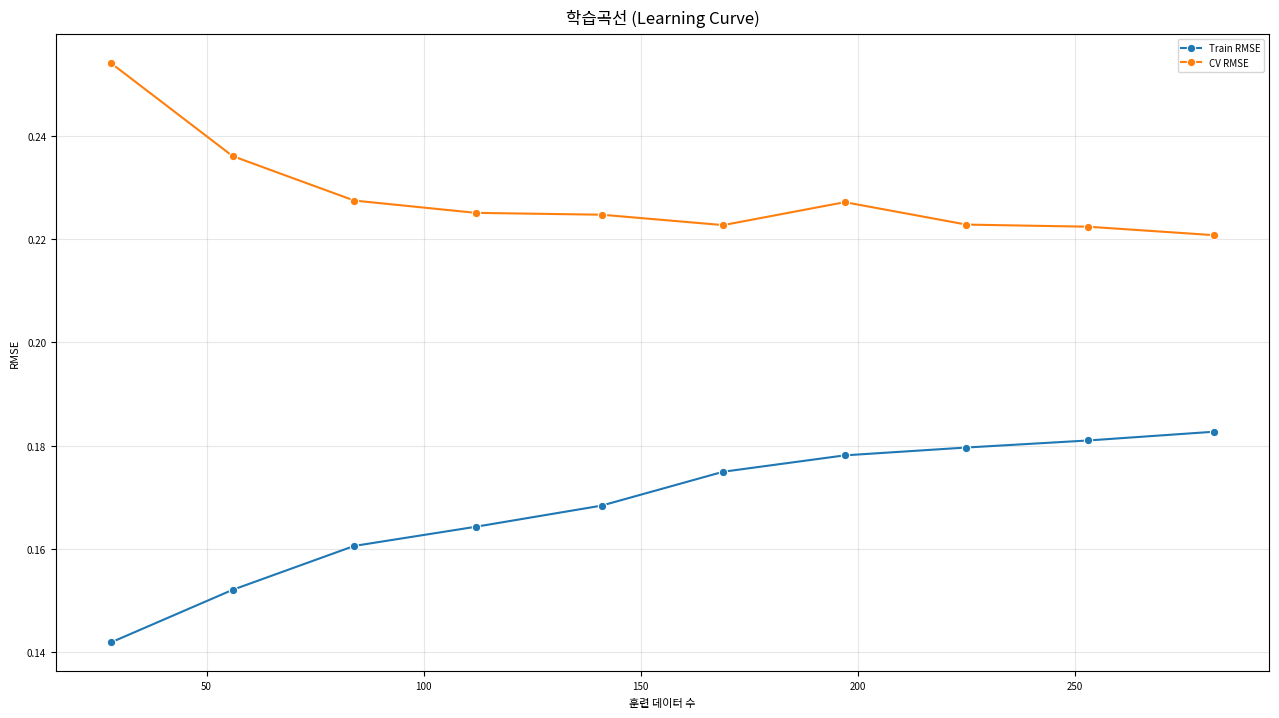

CPU times: user 388 ms, sys: 28.5 ms, total: 417 ms
Wall time: 4.1 s


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
AdaBoostRegressor,0.773,0.151,0.033,0.182,0.009,-0.063,0.183,0.221,0.016,0.827,0.074,✅ 일반화 양호


In [14]:
%%time

ada = AdaBoostRegressor(
    estimator=best_model,   # 이미 GridSearch로 튜닝된 트리
    random_state=52
)

param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.3, 1.0],
    "loss": ["linear", "square", "exponential"],
}

gs_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

gs_ada.fit(x_train, y_train)

best_ada_model = gs_ada.best_estimator_

hs_get_score_cv(best_ada_model, x_train, y_train, x, y)


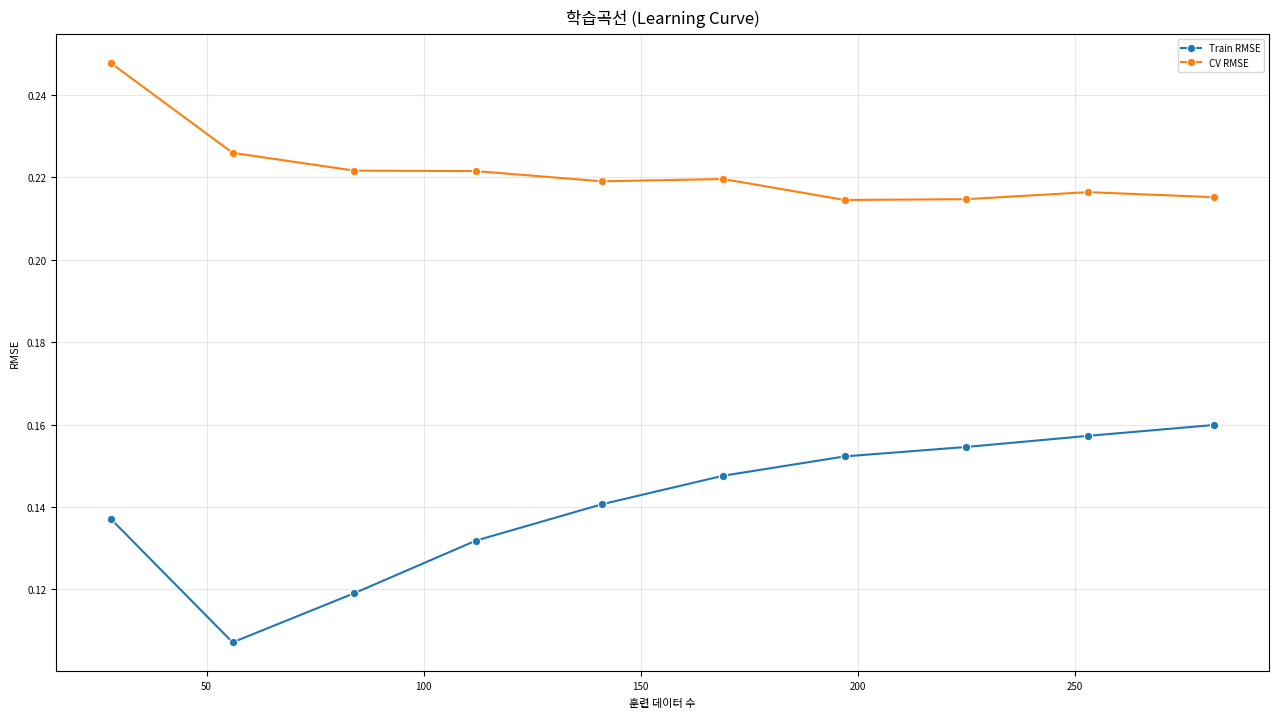

CPU times: user 13.9 s, sys: 1.04 s, total: 14.9 s
Wall time: 3min 46s


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
GradientBoostingRegressor,0.828,0.125,0.025,0.159,0.008,-0.001,0.160,0.215,0.012,0.743,0.054,⚠️ 과대적합 (variance 큼)


In [15]:
%%time

gbr = GradientBoostingRegressor(
    random_state=52
)

param_grid = {
    "n_estimators": [100, 200, 300],  # [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 5, 7],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 5, 10, 20],
    "subsample": [0.6, 0.8, 1.0],
    "max_features": [None, "sqrt", "log2"],
    "loss": ["squared_error"],  # ["squared_error", "absolute_error", "huber"],
}

gs_gbr = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

gs_gbr.fit(x_train, y_train)

best_gbr_model = gs_gbr.best_estimator_

hs_get_score_cv(best_gbr_model, x_train, y_train, x, y)
